In [1]:
import pandas as pd
from src.dataset import load_dataset, load_task_split

df_fact_check, df_posts, df_fact_check_mapping = load_dataset(data_folder="data/complete_data", trial=False)
df_fact_check = df_fact_check.reset_index()
df_posts = df_posts.reset_index()

df_posts.columns = ["ps_" + col if col not in ["post_id"] else col for col in df_posts.columns]
df_fact_check.columns = ["fc_" + col if col not in ["fact_check_id"] else col for col in df_fact_check.columns]

print(df_fact_check.shape, df_posts.shape, df_fact_check_mapping.shape)

ModuleNotFoundError: No module named 'src'

In [4]:
tasks_path = "data/complete_data/tasks.json"
tasks = load_task_split(tasks_path)

monolingual --------- ['fra', 'spa', 'eng', 'por', 'tha', 'deu', 'msa', 'ara']
	 fra --------- ['fact_checks', 'posts_train', 'posts_dev']
	 spa --------- ['fact_checks', 'posts_train', 'posts_dev']
	 eng --------- ['fact_checks', 'posts_train', 'posts_dev']
	 por --------- ['fact_checks', 'posts_train', 'posts_dev']
	 tha --------- ['fact_checks', 'posts_train', 'posts_dev']
	 deu --------- ['fact_checks', 'posts_train', 'posts_dev']
	 msa --------- ['fact_checks', 'posts_train', 'posts_dev']
	 ara --------- ['fact_checks', 'posts_train', 'posts_dev']
crosslingual --------- ['fact_checks', 'posts_train', 'posts_dev']
	 fact_checks --------- [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
	 posts_train --------- [3, 16, 30, 60, 62, 71, 74, 75, 76, 77]
	 posts_dev --------- [34, 57, 116, 133, 283, 309, 322, 351, 354, 373]


In [143]:
import ast
import json
from abc import abstractmethod
import numpy as np
from typing import List

class Dataset:
    """
    This is the base class for all datasets. It loads the data and tasks dictionary.
    Inputs:

    path: Path to the dataset
    tasks_path: Path to the tasks dictionary
    task_name: Name of the task (monolingual or crosslingual)
    lang: Language of the dataset (default: eng)
    version: Version of the dataset (default: None) Options ["english", "original"]
    index_col: Index column for the dataset (default: None) Important for splitting the dataset
    iter_cols: Columns that need to be iterated over (default: []) Important for preprocessing the dataset
    """
    def __init__(self, path: str, tasks_path: str, task_name:str, 
                 lang: str="eng", version:str=None, index_col:str=None, 
                 iter_cols:List[str]=[]):
        
        assert task_name in ["monolingual", "crosslingual"]
        self.path = path
        self.task_name = task_name
        self.tasks_path = tasks_path
        self.lang = lang
        self.index_col = index_col
        self.iter_cols = iter_cols

        # Load tasks dictionary
        self.tasks = self.load_tasks()
        self.langs = list(self.tasks["monolingual"].keys())

        # This ensures we don't get an error in multilingual case
        d_lan = self.get_if_exists(tasks[self.task_name], self.lang)
        self.idx_train, self.idx_dev = d_lan["posts_train"], d_lan["posts_dev"]
        self.idx_fc = d_lan["fact_checks"]

        self.df = self.preprocess_data()

    @staticmethod
    def get_if_exists(dict, key):
        return dict[key] if key in dict else dict
    
    def load_data(self):
        if self.index_col is None:
            df = pd.read_csv(self.path).fillna('')
        else:
            df = pd.read_csv(self.path).fillna('').set_index(self.index_col)
        
        parse_col = lambda s: ast.literal_eval(s.replace('\n', '\\n')) if s else s
        for col in self.iter_cols:
            df[col] = df[col].apply(parse_col)

        return df

    def load_tasks(self):
        return json.load(open(self.tasks_path))

    @abstractmethod
    def preprocess_data(self):
        df_proc = self.load_data()
        return df_proc
    
    def __repr__(self):
        if self.task_name == "monolingual":
            return f"Dataset -- {self.path}, Task: {self.task_name}, Lang: {self.lang}, Size: {self.df.shape}"
        else:
            return f"Dataset -- {self.path}, Task: {self.task_name}, Size: {self.df.shape}"
    

class BasePostsDataset(Dataset):
    
    iter_cols = ['instances', 'ocr', 'verdicts', 'text']
    index_col = "post_id"

    def __init__(self, posts_path, tasks_path, task_name, lang="eng", version=None):
        super().__init__(posts_path, tasks_path, task_name, lang, index_col=self.index_col, iter_cols=self.iter_cols, version=version)

        self.df_train, self.df_dev = self.get_train_dev(self.df)

    def preprocess_data(self):
        df_posts = self.load_data()
        df_posts["text"] = df_posts["text"].apply(lambda x: x[0] if isinstance(x, tuple) else x)
        df_posts["ocr"] = df_posts["ocr"].apply(lambda x: " ".join(trip[0] for trip in x))
        df_posts["verdicts"] = df_posts["verdicts"].apply(lambda x: x[0] if (isinstance(x, list))&(len(x)>0) else "")
        df_posts["instances"] = df_posts["instances"].apply(lambda x: [social for _, social in x] if len(x)>0 else [])
        df_posts["fb"] = df_posts["instances"].apply(lambda x: np.sum(np.array(x)=="fb"))
        df_posts["tw"] = df_posts["instances"].apply(lambda x: np.sum(np.array(x)=="tw"))
        df_posts["ig"] = df_posts["instances"].apply(lambda x: np.sum(np.array(x)=="ig"))

        df_posts.drop(columns=["instances"], inplace=True)
        return df_posts
    
    def get_train_dev(self, df):
        if not self.index_col:
            raise ValueError("Index column for split not set (index_col)")
        return df.loc[self.idx_train, :], df.loc[self.idx_dev, :]
    
    def __repr__(self):
        return super().__repr__().replace("Dataset", "BasePostsDataset") + f", Train: {self.df_train.shape}, Dev: {self.df_dev.shape}"
    

class BaseFactCheckDataset(Dataset):

    iter_cols = ['title', 'claim', "instances"]
    index_col = "fact_check_id"

    def __init__(self, fact_check_path, tasks_path, task_name, lang="eng", version=None):
        super().__init__(fact_check_path, tasks_path, task_name, lang, index_col=self.index_col, iter_cols=self.iter_cols, version=version)
        self.df = self.preprocess_data()
        self.df = self.df.loc[self.idx_fc, :]

    def preprocess_data(self):
        df_fact_check = self.load_data()
        df_fact_check["claim"] = df_fact_check["claim"].apply(lambda x: x[0] if isinstance(x, tuple) else x)
        df_fact_check["title"] = df_fact_check["title"].apply(lambda x: x[0] if isinstance(x, tuple) else x)
        df_fact_check["instances"] = df_fact_check["instances"].apply(lambda x: [url for _, url in x] if len(x)>0 else [])
        return df_fact_check
    
    def __repr__(self):
        return super().__repr__().replace("Dataset", "BaseFactCheckDataset")
    

In [144]:
post_data = BasePostsDataset("data/complete_data/posts.csv", tasks_path, "monolingual", lang="msa")
fc_data = BaseFactCheckDataset("data/complete_data/fact_checks.csv", tasks_path, "crosslingual", lang="msa")

print(post_data)
print(fc_data)

BasePostsDataset -- data/complete_data/posts.csv, Task: monolingual, Lang: msa, Size: (24431, 6) Train: (1062, 6), Dev: (105, 6)
BaseFactCheckDataset -- data/complete_data/fact_checks.csv, Task: crosslingual, Size: (153743, 3)


In [140]:
# abs_data = Dataset("data/complete_data/posts.csv", tasks_path, "monolingual", lang="eng", split=True, index_col="post_id")

# post_data = BasePostsDataset("data/complete_data/posts.csv", tasks_path, "monolingual", lang="msa")
fc_data = BaseFactCheckDataset("data/complete_data/fact_checks.csv", tasks_path, "crosslingual", lang="msa")

fc_data.df.head()

,claim,instances,title
fact_check_id,,,
0,Are avocados good for you?,[https://metafact.io/factchecks/175-are-avocad...,
1,Can animals have headaches?,[https://metafact.io/factchecks/1754-can-anima...,
2,Can we help prevent Alzheimer's with diet?,[https://metafact.io/factchecks/173-can-we-hel...,
3,Do any benefits of alcohol outweigh the risks?,[https://metafact.io/factchecks/172-do-any-ben...,
4,Does acupuncture work for headaches?,[https://metafact.io/factchecks/1752-does-acup...,


In [138]:
print(fc_data.df[fc_data.df["title"] != ""].head().to_markdown())

|   fact_check_id | claim                                                                                                                                                                                                                                          | instances                                                                                                                                                                                                                                                        | title                                                                                            |
|----------------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------

In [122]:
post_data.df_train

,ocr,verdicts,text,fb,tw,ig
post_id,,,,,,
132,"1,4 Juta Warga China Ikut Tes PNS 2021, Persai...",False information,,1,0,0
144,10:14 AM ...0.0KB/s Instagram 83 Σ a Liked by ...,False information,,1,0,0
191,"15:00 0.00 461 0 KB/S 245 t, t 据交警朋友的消息,已经有6名车...",False information and graphic content,,1,0,0
197,"17 Apa 1 Indonesia sakit tenggorokan, meriang ...",False information,,1,0,0
230,2020 DR. Anies Rasyid Baswedan dinobatkan mnja...,,,1,0,0
...,...,...,...,...,...,...
27668,[URL] WEB.DUNIA h3 [USER].INFO.ID Anak laki-la...,Partly False,😢😢😢,0,0,1
27683,KimBim HOLA HESIVS ROMANVS ONT WW,False information,😭😭😭 Bukannya pergi ke Mekkah urus Haji koq mal...,1,0,0
27697,June CK Meng VII Just now done dos 1.... done ...,False information,😱,1,0,0


In [43]:
posts_fr = PostsDataset("data/complete_data/posts.csv", "data/complete_data/tasks.json", "monolingual", lang="fra")

print(posts_fr.df_train.shape, posts_fr.df_dev.shape)

(1596, 4) (188, 4)


In [41]:
posts_fr.tasks["monolingual"].keys()

dict_keys(['fra', 'spa', 'eng', 'por', 'tha', 'deu', 'msa', 'ara'])

In [39]:
posts_fr = PostsDataset("data/complete_data/posts.csv", "data/complete_data/tasks.json", "monolingual", lang="ita")

KeyError: 'posts_train'

In [30]:
posts.df_train.head()

,instances,ocr,verdicts,text
post_id,,,,
64,"[(1610984995.0, fb)]",[(#CouvreFeu18h00: Le gouvernement envisage de...,[],
79,"[(1594053796.0, fb)]",[(* L'eau froide ferme 4 veines du cœur et pro...,[False information],
86,"[(1620518306.0, fb)]",[(*ALERTE INFO DU MINISTERE DE LA SANTE.* Fait...,[False information],
182,"[(1613852722.0, fb)]","[(14 h 24 À compter du 1er mars 2021, le CONFI...",[False information],
192,"[(1584298244.0, fb)]",[(15:15 : = all 5% La FRANCE au STADE 4 Ce que...,[False information],


In [77]:
df_lens_ps = df_posts.map(lambda x: len(x) if type(x) in [list, tuple] else 0)
df_lens_ps.describe()

,post_id,instances,ocr,verdicts,text
count,24431.0,24431.000000,24431.000000,24431.000000,24431.000000
mean,0.0,1.041177,0.574066,0.812861,2.698662
std,0.0,0.230020,0.627769,0.398133,0.901800
min,0.0,1.000000,0.000000,0.000000,0.000000
25%,0.0,1.000000,0.000000,1.000000,3.000000
50%,0.0,1.000000,1.000000,1.000000,3.000000
75%,0.0,1.000000,1.000000,1.000000,3.000000
max,0.0,5.000000,10.000000,2.000000,3.000000


In [81]:
df_posts[df_lens_ps["ocr"] > 4]["ocr"].iloc[0]

[("FOLLOW US ON FACEBOOK Global Public RED ALERT! COMMUNIST TERRORIST Terrorist Bitch Lands in Red Paper Inquirer's Choice No. 1 SARAH ELAGO KABATAAN Partylist Representative Recruiter of the Year #JunkTerrorists #HandsOffOurChildren KABATAAN PARTYLIST #NoToCPPNPANDF #YesToAntiTerrorismLaw",
  "FOLLOW US ON FACEBOOK Global Public RED ALERT! COMMUNIST TERRORIST Terrorist Bitch Lands in Red Paper Inquirer's Choice No. 1 SARAH ELAGO KABATAAN Partylist Representative Recruiter of the Year #JunkTerrorists #HandsOffOurChildren KABATAAN PARTYLIST #NoToCPPNPANDF #YesToAntiTerrorismLaw",
  [('eng', 0.823550820350647), ('fil', 0.13627982139587402)]),
 ("FOLLOW US ON FACEBOOK Global Public RED ALERT! COMMUNIST TERRORIST Terrorist Bitch Lands in Red Paper Inquirer's Choice No. 2 KARA TAGGAOA National Spokeperson for the League of Filipino Students (LFS) League of Filipino Students et Brugje can the band a de yout #JunkTerrorists #HandsOffOurChildren #NoToCPPNPANDF #YesToAntiTerrorismLaw",
  "FOLLO

In [76]:
df_lens_fc = df_fact_check.map(lambda x: len(x) if type(x) in [list, tuple] else 0)
df_lens_fc.describe()

,fact_check_id,fc_claim,fc_instances,fc_title
count,153743.0,153743.0,153743.000000,153743.000000
mean,0.0,3.0,1.015929,2.739871
std,0.0,0.0,0.132962,0.844230
min,0.0,3.0,1.000000,0.000000
25%,0.0,3.0,1.000000,3.000000
50%,0.0,3.0,1.000000,3.000000
75%,0.0,3.0,1.000000,3.000000
max,0.0,3.0,7.000000,3.000000


<Axes: >

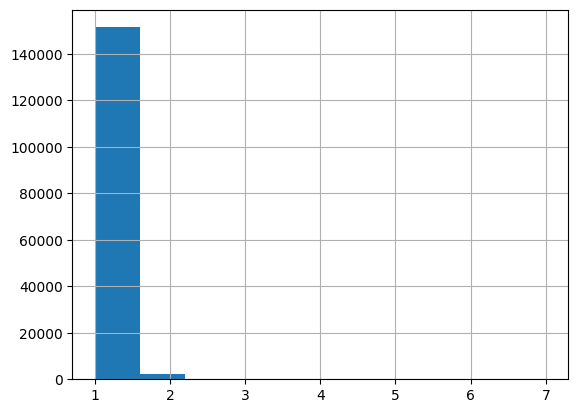

In [36]:
df_lens["fc_instances"].hist()

,post_id,instances,ocr,verdicts,text
0,0,"[(1608571882.0, fb)]",[(! Dreister Impf-Fake von Markus Söder! Es is...,[False information],
1,1,"[(1586139153.0, fb)]",[(!! WARNING !! A new thing circulating now. P...,[False information],
2,2,"[(1610052141.0, fb), (1610072448.0, fb)]","[(""Actually, he's a damn sight better than any...",[Missing context],
3,3,"[(1645187790.0, ig)]","[(""Australia 50 MILLONES de dosis de ""vacuna"" ...",[False],
4,4,"[(1581697500.0, fb)]","[(""Bienaventurados los perseguidos por mi caus...",[],
...,...,...,...,...,...
24426,28085,"[(1651921264.0, fb), (1651882168.0, fb)]",[],[Partly false information],(🧐Se separó el presidente...la constitución de...
24427,28087,"[(1653138895.0, fb)]",[(bruising runny ed 1 e Contents of the pack a...,[Missing context],"(🧐🧐🧐, 🧐🧐🧐, [(eng, 1.0)])"
24428,28089,"[(1657134606.0, fb)]",[],[Partly false information],"(🧬Robert Malone, inventeur de la technologie A..."
24429,28090,"[(1646255245.0, tw)]",[(Number of Covid-19 Deaths 4500 4000 3500 300...,[],(🧵Enquanto você se distrai com a invasão da Rú...


In [ ]:
df_posts = 

In [4]:
df_posts

,post_id,ps_instances,ps_ocr,ps_verdicts,ps_text
0,0,"[(1608571882.0, fb)]",[(! Dreister Impf-Fake von Markus Söder! Es is...,[False information],
1,1,"[(1586139153.0, fb)]",[(!! WARNING !! A new thing circulating now. P...,[False information],
2,2,"[(1610052141.0, fb), (1610072448.0, fb)]","[(""Actually, he's a damn sight better than any...",[Missing context],
3,3,"[(1645187790.0, ig)]","[(""Australia 50 MILLONES de dosis de ""vacuna"" ...",[False],
4,4,"[(1581697500.0, fb)]","[(""Bienaventurados los perseguidos por mi caus...",[],
...,...,...,...,...,...
24426,28085,"[(1651921264.0, fb), (1651882168.0, fb)]",[],[Partly false information],(🧐Se separó el presidente...la constitución de...
24427,28087,"[(1653138895.0, fb)]",[(bruising runny ed 1 e Contents of the pack a...,[Missing context],"(🧐🧐🧐, 🧐🧐🧐, [(eng, 1.0)])"
24428,28089,"[(1657134606.0, fb)]",[],[Partly false information],"(🧬Robert Malone, inventeur de la technologie A..."
24429,28090,"[(1646255245.0, tw)]",[(Number of Covid-19 Deaths 4500 4000 3500 300...,[],(🧵Enquanto você se distrai com a invasão da Rú...


In [10]:
from datasets import load_dataset

data = load_dataset("json", data_files="data/complete_data/tasks.json", split=None)
data["train"]["monolingual"]

[{'fra': {'fact_checks': [15,
    136,
    155,
    156,
    187,
    214,
    584,
    1187,
    1193,
    1231,
    1440,
    1441,
    1442,
    1663,
    2644,
    2645,
    3035,
    3193,
    3196,
    3204,
    3215,
    3232,
    3233,
    3271,
    3273,
    3283,
    3284,
    3329,
    3361,
    3557,
    3941,
    3942,
    4388,
    4738,
    4865,
    4866,
    5116,
    5171,
    6298,
    6412,
    6452,
    7807,
    8594,
    8596,
    8629,
    8630,
    8768,
    8778,
    8779,
    8800,
    8848,
    8869,
    8937,
    8997,
    9001,
    9119,
    9133,
    9186,
    9199,
    9319,
    9330,
    9342,
    9348,
    9353,
    9362,
    9667,
    9699,
    9712,
    9731,
    9783,
    9811,
    9825,
    9869,
    9875,
    9897,
    9938,
    9980,
    9989,
    10049,
    10061,
    10113,
    10128,
    10137,
    10138,
    10147,
    10164,
    10165,
    10212,
    10241,
    10242,
    10243,
    10250,
    10273,
    10274,
    10294,
    10309,
    1031